In [56]:
# Импорт библиотек
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [42]:
# Обозначим размеры изображений
image_width = 224
image_height = 224

In [ ]:
# Создадим функцию для конвертации изображений в JPEG-формат
def convert_images_to_jpeg(input_directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    for filename in os.listdir(input_directory):
        if filename.endswith('.png') or filename.endswith('.till'):
            image = Image.open(os.path.join(input_directory, filename))
            output_file = os.path.join(output_directory, os.path.splitext(filename)[0] + '.jpeg')
            image.save(output_file, 'JPEG')

In [43]:
# Создадим переменные с директорией каждого лейбла
path_brain = '/content/drive/MyDrive/MRI/brain'
path_heart = '/content/drive/MyDrive/MRI/heart'
path_prostate = '/content/drive/MyDrive/MRI/prostate'
path_lumbar_spine = '/content/drive/MyDrive/MRI/lumbar_spine'

In [21]:
# Конвертируем файлы каждого лейбла в JPEG
convert_images_to_jpeg(path_brain, '/content/drive/MyDrive/MRI/train/brain')
convert_images_to_jpeg(path_heart, '/content/drive/MyDrive/MRI/train/heart')
convert_images_to_jpeg(path_lumbar_spine, '/content/drive/MyDrive/MRI/train/lumbar_spine')
convert_images_to_jpeg(path_prostate, '/content/drive/MyDrive/MRI/train/prostate')

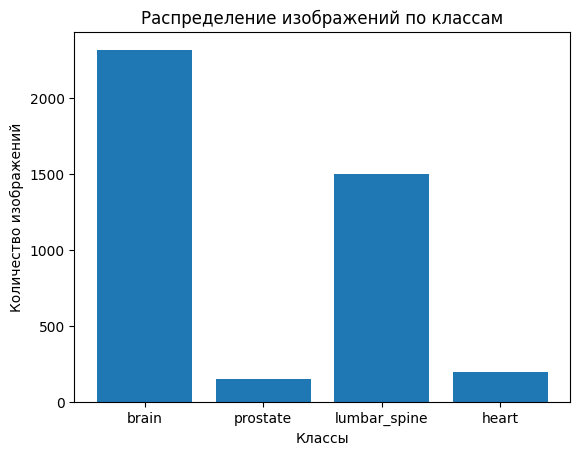

In [44]:
# Построим график распределения изображений по классам
class_count = {}
labels_folder = '/content/drive/MyDrive/MRI/train'
for folder in os.listdir(labels_folder):
    folder_path = os.path.join(labels_folder, folder)
    image_count = len(os.listdir(folder_path))
    class_count[folder] = image_count

classes = list(class_count.keys()) # создаем список классов
counts = list(class_count.values()) # создаем список с количеством изображений внутри каждого класса

plt.bar(classes, counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по классам')
plt.show()

In [45]:
# Создадим генератор данных для аугментации
datagen = ImageDataGenerator(
    rotation_range=15, # случайные повороты в диапазоне от -15 до 15 градусов
    width_shift_range=0.1, # случайные сдвиги по горизонтали на 10% от ширины изображения
    height_shift_range=0.1, # случайные сдвиги по вертикали на 10% от высоты изображения
    zoom_range=0.1, # случайное масштабирование на 10%
    brightness_range=[0.8, 1.2], # случайные изменения яркости в диапазоне от 0.8 до 1.2
    rescale=1./255, # нормализация значений пикселей
    validation_split=0.2
)

In [46]:
# Создадим генератор данных для обучающей выборки
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/MRI/train',
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=12345
)

Found 3329 images belonging to 4 classes.


In [47]:
# Создадим генератор данных для валидационной выборки
validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/MRI/train',
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=12345
)

Found 830 images belonging to 4 classes.


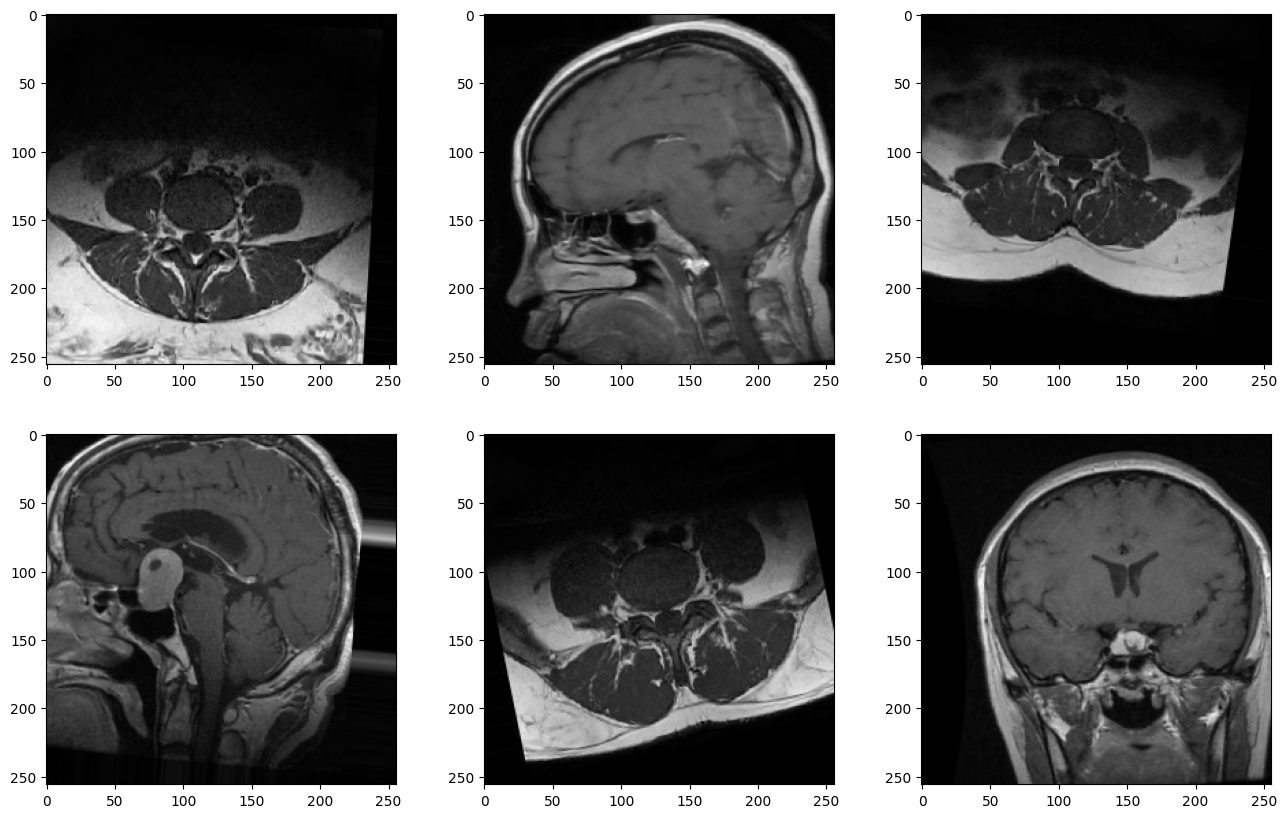

In [30]:
# Посмотрим на случайные 6 изображений
features, target = next(train_generator)
pic_box = plt.figure(figsize=(16, 10))
for i in range(6):
    pic_box.add_subplot(2, 3, i+1)
    plt.imshow(features[i])

In [48]:
# Создадим модель для обучения
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer = 'Adam',metrics=['accuracy'])

In [49]:
# Обучим модель
train_steps = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=3,
                    validation_data=validation_generator, validation_steps=validation_steps)

Epoch 1/3
104/104 [==============================] - 427s 4s/step - loss: 0.3386 - accuracy: 0.9311 - val_loss: 0.1417 - val_accuracy: 0.9563
Epoch 2/3
104/104 [==============================] - 370s 4s/step - loss: 0.0798 - accuracy: 0.9806 - val_loss: 0.0886 - val_accuracy: 0.9663
Epoch 3/3
104/104 [==============================] - 358s 3s/step - loss: 0.0577 - accuracy: 0.9885 - val_loss: 0.0646 - val_accuracy: 0.9812


In [52]:
# Загрузим сохраненную модель
model.save('/content/drive/MyDrive/MRI/my_model_MRI.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


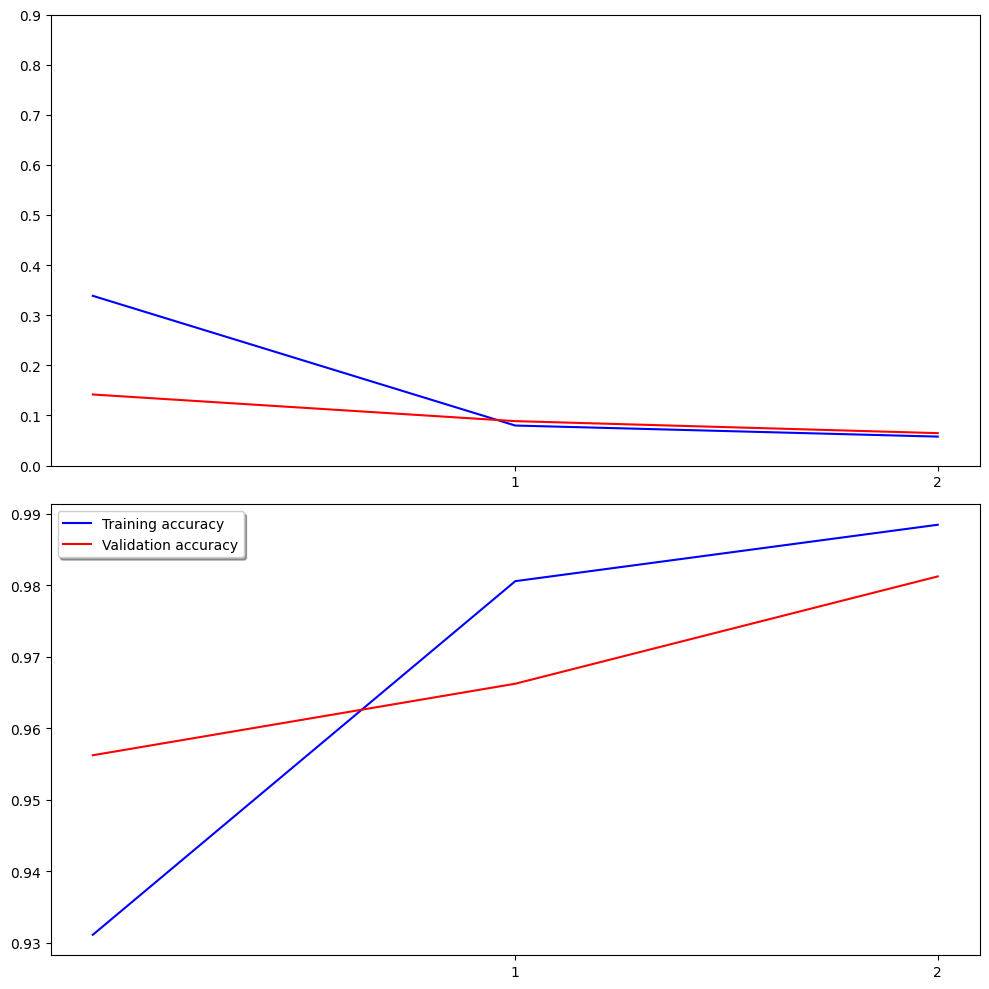

In [50]:
# Построим графики динамики обучения модели в зависимости от эпох
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 3, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 3, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [54]:
# Создадим функцию для классификации тестовых изображений
def test_classification(model, path=None):
    test = os.listdir(path)
    df_test = pd.DataFrame({'file_name': (i for i in test)})
    test_datagen = ImageDataGenerator(rescale=1/255.0)
    test_generator = test_datagen.flow_from_dataframe(directory=path, target_size=(224,224),
                                                 dataframe=df_test,
                                                 x_col='file_name',
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=12345)
    test_generator.reset()
    pred=model.predict(test_generator)
    predictions = []
    for i in pred:
        if np.argmax(i) == 0:
            predictions.append('brain')
        elif np.argmax(i) == 1:
            predictions.append('heart')
        elif np.argmax(i) == 2:
            predictions.append('lumbar_spine')
        elif np.argmax(i) == 3:
            predictions.append('prostate')
    filenames=test_generator.filenames
    results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
    return results

In [59]:
# Проверка модели на тесте
test_classification(model, path='/content/drive/MyDrive/MRI/test/3')

Found 4 validated image filenames.
4/4 [==============================] - 2s 415ms/step


,Filename,Predictions
0,5_png.rf.d4efbd46faff54a3a73a30ddef6c0c22.jpg,heart
1,8_png.rf.23f4451b487c1dd344bb62753262d5aa.jpg,heart
2,33_png.rf.e31cc409373cbc76693000bdddc8b015.jpg,heart
3,20_png.rf.0f4fefcbe3aae6a45cc7a235df415f0d.jpg,heart
